In [1]:
import sys
import os
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
shap_sub = pd.read_hdf(f'/nobackup/users/straaten/interpretation/{name}_shap_sub.h5', key = 'explanation')
outpos = pd.read_hdf(f'/nobackup/users/straaten/interpretation/{name}_outpos.h5', key = 'values')
nsamples = len(shap_sub.index)
aliases = pd.Series(['trop. west pacif. sst','north sea sst','subtrop. 850 hPa T','scand. soilm. depletion'], index = shap_sub.columns)
shap_sub.columns = aliases

In [3]:
# Defining interesting slices:
tele = slice(0,300)
tele_countered = slice(435,590)
swvl_driven = slice(2220,nsamples)

slices = {'west_pacific':tele,'soilm_counter':tele_countered,'soilm_driven':swvl_driven}

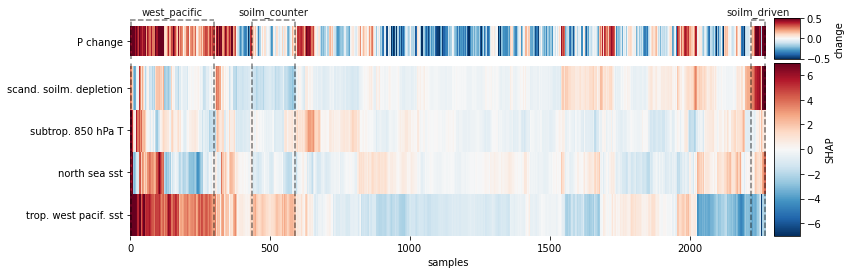

In [151]:
order = shap_sub.index
response = 'change'

fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 5, ncols = 20, hspace=0.1, wspace = 0.3)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -7, vmax = 7, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
ax_expl.set_xlabel('samples')

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

fig.colorbar(expl, cax = ax_cbar_expl, label = 'SHAP')
fig.colorbar(cor, cax = ax_cbar_cor, label = response)

for i in ax_expl.spines:
    ax_expl.spines[i].set_visible(False)
    ax_cor.spines[i].set_visible(False)

expl_height = 4.1
cor_height = 1.2
color = 'black'
alpha = 0.5
ls = '--'
for key, sl in slices.items():
    ax_expl.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_expl.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_cor.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_cor.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_cor.hlines(y = cor_height, xmin = sl.start, xmax = sl.stop, color = color, alpha = alpha, linestyles = ls)
    ax_cor.text(x = np.mean([sl.start,sl.stop]), y = cor_height + 0.1, s = key, color = color, alpha = 0.9, verticalalignment = 'bottom', horizontalalignment = 'center')

ax_expl.set_ylim(bottom = 0, top = expl_height)
ax_cor.set_ylim(bottom = -0.1)
plt.show()

In [3]:
z_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/z300_nhnorm.anom.nc')
z_31 = xr.open_dataset('/nobackup_1/users/straaten/processed/z300_nhnorm.31.anom.nc')[z_daily.name]

sst_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/sst_nhplus.anom.nc')
sst_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/sst_nhplus.21.anom.nc')[sst_daily.name]

swvl13_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/swvl13_europe.anom.nc')
swvl13_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/swvl13_europe.21.anom.nc')[swvl13_daily.name]

t850_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/t850_nhblock.anom.nc')
t850_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/t850_nhblock.21.anom.nc')[t850_daily.name]

In [155]:
timestamps = shap_sub.index[tele].get_level_values('time').unique()
# Test only:
#timestamps = timestamps.intersection(prepared_data.crossval.obs_test.index.get_level_values('time'))

In [156]:
timestamps.year.unique()

Int64Index([2015, 2006, 2002, 2003, 2005, 2018, 2009, 2004], dtype='int64', name='time')

In [6]:
def data_for_pcolormesh(array, shading:str):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    if shading == 'flat':
        lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
        lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge (only for flat shating)
    return lons, lats, array.values.squeeze()

In [8]:
array_crs = ccrs.PlateCarree()
proj_crs = ccrs.Robinson()
shading = 'nearest'

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/us

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/us

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/nobackup_1/users/straaten/VENV/lib64/py

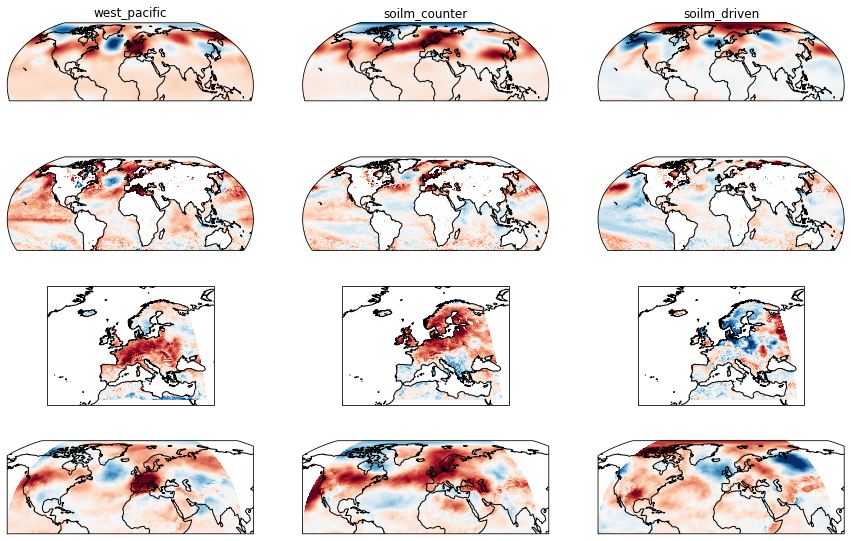

In [173]:
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, nrows = 4, ncols = len(slices), squeeze = False, figsize = (15,10))
max_level = 0.99

for j, (key, sl) in enumerate(slices.items()):
    timestamps = shap_sub.index[sl].get_level_values('time').unique()
    for i, (var,cmap) in enumerate(zip([z_31,sst_21,swvl13_21,t850_21],['RdBu_r','RdBu_r','RdBu','RdBu_r'])):
        comp = var.loc[timestamps,:,:].mean('time')
        vmax = float(np.abs(comp.quantile([(1-max_level),max_level]).values).max())
        axes[i,j].pcolormesh(*data_for_pcolormesh(comp, shading = shading), zorder = 1, shading = shading, 
                  transform = array_crs, cmap = cmap, vmax = vmax, vmin = -vmax)
        axes[i,j].coastlines(zorder = 2, lw = 1)
    axes[0,j].set_title(key)

In [19]:
# Over or under-estimation (of average temperature, not binarized yet)
test = pd.read_hdf('/nobackup_1/users/straaten/match/paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean_e39fc4cbb84c4f9ab1fa4b346eb9aa42.h5')
test['separation'] = test['leadtime'] -1
test = test.set_index(['time','clustid','separation']).sort_index().loc[(slice(None),9,slice(None)),:]
test.index = test.index.droplevel('clustid')

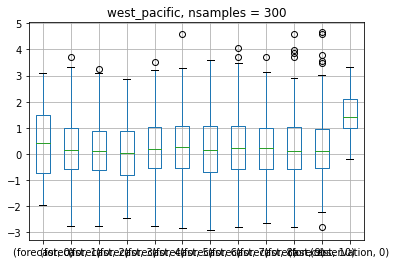

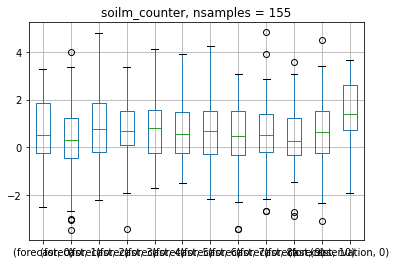

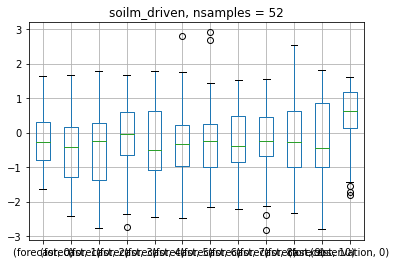

In [28]:
for key, sl in slices.items():
    sample = test.loc[shap_sub.index[sl],['forecast','observation']]
    ax = sample.boxplot()
    ax.set_title(f'{key}, nsamples = {len(sample)}')
    plt.show()

In [4]:
# Predicted.
highest = xr.open_dataarray('/nobackup/users/straaten/interpretation/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_1950shap_z300highest.nc')
ensmean = xr.open_dataarray('/nobackup/users/straaten/interpretation/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_1950shap_z300ensmean.nc')

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


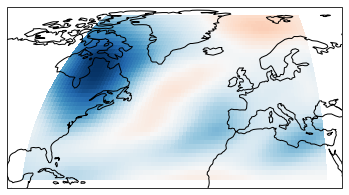

In [9]:
proj_crs = ccrs.Robinson(central_longitude=0)

fig, ax = plt.subplots(subplot_kw = {'projection':proj_crs}, nrows = 1, squeeze = True)
ax.pcolormesh(*data_for_pcolormesh(ensmean, shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r', vmax = 100)
ax.coastlines(zorder = 2, lw = 1)

In [174]:
# Observed pattern during initialization that informs the correction (and correspondence to the correlation pattern)
# init time = valid_time - (separation + 1)
init_timestamps = shap_sub.index.get_level_values('time') - pd.TimedeltaIndex(shap_sub.index.get_level_values('separation') + 1, unit = 'day')

In [188]:
clust = xr.open_dataset('/nobackup_1/users/straaten/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)
clust = clust.sel(fold = 4, lag = -(15+21))
corrpattern = clust['correlation'].where(clust['clustid'] == 4, np.nan)

In [176]:
sstinit = sst_21.loc[init_timestamps[tele],...].mean('time')

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/nobackup_1/us

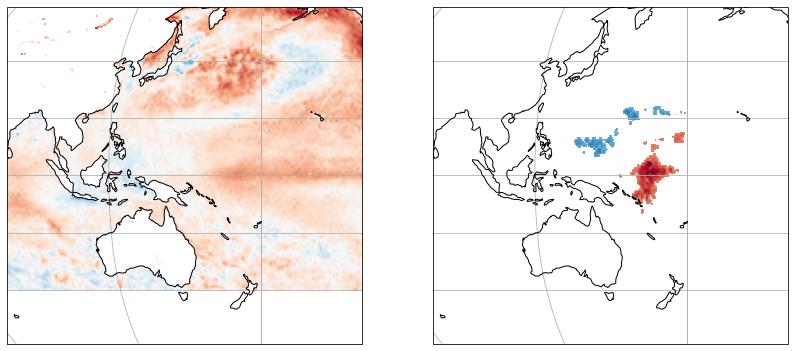

In [192]:
proj_crs = ccrs.Robinson(central_longitude=180)
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = 2, squeeze = True, figsize = (14,8))

for i, (data,vmax) in enumerate(zip([sstinit,corrpattern],[1.5,0.25])):
    ax = axes[i]
    ax.set_extent((80,-140,-30,30))
    ax.pcolormesh(*data_for_pcolormesh(data, shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = -vmax,vmax = vmax)
    ax.coastlines(zorder = 2, lw = 1)
    ax.gridlines()